# Exercise 8

## Car Price Prediction

Predict if the price of a car is low or high

### Integrantes del Grupo:

* Jorge Enrique Gonzalez Garcia (201920233)
* Daniel Camilo Rojas Arcila (201924286)
* Julian Andrés Velasquez Osorio (201014210)
* Fernando Pérez Moreno (200222809)

In [1]:
%matplotlib inline
import pandas as pd

data = pd.read_csv('../ModeloAvanzadosDecisionTrees/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
data.shape

(13150, 10)

In [3]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Exercise 8.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [5]:
import pandas as pd
import numpy as np

In [6]:
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

In [7]:
j = 1
print(X.columns[j])

Mileage


In [8]:
# Split the variable in num_ctp points
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())

In [9]:
# Only unique values for filter binary and few unique values features
splits = np.unique(splits)

In [10]:
splits

array([5.00000e+00, 1.58728e+04, 2.32508e+04, 2.98747e+04, 3.56432e+04,
       4.16580e+04, 4.83404e+04, 6.16152e+04, 8.07292e+04, 1.06371e+05])

In [11]:
k = 5
filter_l = X.iloc[:, j] < splits[k]

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [12]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [13]:
gini_l = gini(y_l)
gini_l

0.20562506325087826

In [14]:
gini_r = gini(y_r)
gini_r

0.3991431537249346

In [15]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [16]:
gini_impurity(X.iloc[:, j], y, splits[k])

0.18496148274516044

In [17]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [18]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [19]:
tree_grow(X, y, level=0, min_gain=0.001, max_depth=1, num_pct=10)

{'y_pred': 1,
 'y_prob': 0.5795316301703163,
 'level': 0,
 'split': [1, 51704.54545454545],
 'n_samples': 13150,
 'gain': 0.23348567756020572,
 'sl': {'y_pred': 1,
  'y_prob': 0.8377538829151733,
  'level': 1,
  'split': -1,
  'n_samples': 8368,
  'gain': 0.0359166442135464},
 'sr': {'y_pred': 0,
  'y_prob': 0.12771739130434784,
  'level': 1,
  'split': -1,
  'n_samples': 4782,
  'gain': 0.04846022210319853}}

In [38]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [29]:
data.head(2)

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1


In [39]:
tree

{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': [1, 52187.63636363637],
 'n_samples': 8810,
 'gain': 0.23872134898880762,
 'sl': {'y_pred': 1,
  'y_prob': 0.8391583452211127,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 5606,
  'gain': 0.03317687167496233,
  'sl': {'y_pred': 0,
   'y_prob': 0.36828644501278773,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 389,
   'gain': 0.05908490521197157,
   'sl': {'y_pred': 0,
    'y_prob': 0.08,
    'level': 3,
    'split': -1,
    'n_samples': 98,
    'gain': 0.01707452211653898},
   'sr': {'y_pred': 0,
    'y_prob': 0.46757679180887374,
    'level': 3,
    'split': -1,
    'n_samples': 291,
    'gain': 0.036947257392555666}},
  'sr': {'y_pred': 1,
   'y_prob': 0.8743054224947308,
   'level': 2,
   'split': [0, 2015.0],
   'n_samples': 5217,
   'gain': 0.014933378976312917,
   'sl': {'y_pred': 1,
    'y_prob': 0.7348484848484849,
    'level': 3,
    'split': -1,
    'n_samples': 1450,
    'gain': 0.024495220

In [34]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted    

### Tree prediction with max_depth=None:
The accuracy with maxdepth = None is 84.3% lower thant the accuracy found below with max depth= 6 (87.7%). We found that maxdepth with value 6 is higher than with higher values, tehrefore it seems that for this case the optimal max_depth seems to be 6. However in 8.3 Exercise we will analize the maxdepth effect in accuracy as wer vary this parameter.

In [43]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10)
y_pred=tree_predict(X_test, tree)
#Obteniendo el Accuracy
from sklearn import metrics
metrics.accuracy_score(y_pred, y_test)

0.8433179723502304

In [52]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=6, num_pct=10)
y_pred=tree_predict(X_test, tree)
from sklearn import metrics
metrics.accuracy_score(y_pred, y_test)

0.8771889400921659

# Exercise 8.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #7

Evaluate the accuracy on the testing set

In [54]:
X.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
15,2016,29242,0,0,0,0,1,0,0
47,2015,26465,0,0,0,0,1,0,0
85,2012,46739,0,1,0,0,0,0,0
141,2017,41722,0,0,0,0,0,1,0
226,2014,77669,0,0,0,0,0,0,1


Revisando que las clases estén balanceadas, esto se puede evidenciar ya que no hay diferencias significativas (57% y 42%)

In [55]:
y.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
1,7621,0.579544
0,5529,0.420456


#### Creating the 10 samples randomly with replacement ,this is  Bootstrap

In [56]:
n_estimators = 10
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

#### Defining the 10 tree classifiers and fitting them to the train set

In [57]:
from sklearn.tree import DecisionTreeClassifier

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=None, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

### Applying majority Voting to the trees in order to predict
#### Performing the ten predictionso over test set  with the tree classifier

In [58]:
# Predict 
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

,0,1,2,3,4,5,6,7,8,9
332784,0,0,0,0,1,1,0,1,1,1
146436,1,1,1,1,1,1,1,1,1,1
130476,1,1,1,1,1,1,1,1,1,1
85618,1,1,1,1,1,1,1,1,1,1
75474,0,0,0,0,0,0,0,0,0,0


#### Summarising  predictions for each observation telling us how many of the ten trees defined predicted one. 

In [59]:
y_pred_df.sum(axis=1)[:10]

332784     5
146436    10
130476    10
85618     10
75474      0
330419     0
205915    10
2836       8
250833    10
126784     0
dtype: int64

#### Calculating Accuracy with max depth = None, and =6, in order to compare the result with the found above in exercise 8.1. 
We could see that in 8.1 Accuracy was: 84.3%  & 87.7%  with max depth =  None & 6 respectively 
And with 8.2             Accuracy is:  84.2%  & 87.9%  with  max depth = None & 6 respectively 
We can conclude that when using bagging and enssembling 10 trees the accuray is better with max depth in 6. There fore an improvement can be made by enssembling many trees

In [60]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

from sklearn import metrics
metrics.f1_score(y_pred, y_test)

0.8658823529411764

In [61]:
metrics.accuracy_score(y_pred, y_test)

0.8423963133640553

In [63]:
from sklearn.tree import DecisionTreeClassifier

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=6, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

    # Predict 
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

y_pred_df.sum(axis=1)[:10]

y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

from sklearn import metrics

metrics.accuracy_score(y_pred, y_test)

0.8790322580645161

# Exercise 8.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

## Solution 8.3
Lets first define the tree_grow before making predictions to evaluate the accuracy

In [19]:
# Defining parameters
import pandas as pd
import numpy as np

max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

#### Following, we define the 3 functions neccesary for later grow the tree with the recursively function and then predicit. These three fuctions are: 
1. gini function based on the ymeans equations shown bellow
2. gini_impurity function: calculates the impurity of the branches right or left, calculated based on gini equation substraction,  and depends of the feature, y, and the split
3. Best split: returns the feature (x var), the split (based on percentice), and the gain

In [ ]:
# gini
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)


    # Defining gini_impurity 
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_


# Definign Best Split Function, returns the freature (x var), the split (based on percentice), and the gain
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

#### Defining the growth tree function

In [47]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [118]:
tree_grow(X, y, level=0, min_gain=0.001, max_depth=0, num_pct=10)

{'y_pred': 1,
 'y_prob': 0.5795316301703163,
 'level': 0,
 'split': -1,
 'n_samples': 13150,
 'gain': 0.23348567756020572}

#### Defining the tree_predict function

In [49]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted    

### Changing the parameter max_depth to apply the predict function on the tree over test data. Then calculating accuracy for each max_depth
In the graph bellow, we can see how the accuracy at depth of 1 starts already in 84%, however as the max_depth increases the accuracy too, reaching its peak around 88% accuracy in a max_depth of 6, after that point, it start decreasing again, by the 14 depth is in 85%.  
With this it can be concluded that more depth is better ONLY until certain point, too much depth starts to affect accuracy. 

In [119]:
from sklearn import metrics
results=pd.DataFrame(columns=['max_depth', 'Accuracy'])

for depth in range(1,15):
    tree=tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=depth, num_pct=10)
    tree_predict(X_test, tree)
    accuracy=metrics.accuracy_score(y_test,tree_predict(X_test, tree))
    results = results.append({'max_depth': depth, 'Accuracy': accuracy}, ignore_index=True)

Text(0, 0.5, 'Accuracy')

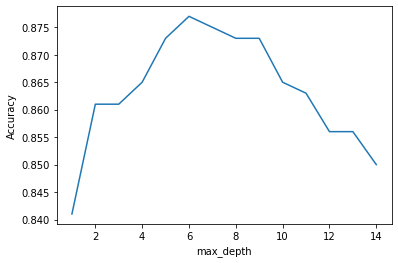

In [120]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

results.Accuracy=round(results.Accuracy,3)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(results.max_depth, results.Accuracy)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')



In [114]:
results

,max_depth,Accuracy
0,0.0,0.582
1,1.0,0.841
2,2.0,0.861
3,3.0,0.861
4,4.0,0.865
5,5.0,0.873
6,6.0,0.877
7,7.0,0.875
8,8.0,0.873
9,9.0,0.873


# Exercise 8.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

# Performing Bagging Classifier with log(n_features) & comparing results with nfeatures= n_features

As we already did manually the bagging algorithm in 8.2 exercise, here we are going to apply directly the baggingClassifier function from sklearn, and change the parameter n_stimators to make sure we estimate 10 decision trees as requested. 
Later we do the same but not wwith log(features) but with the number of features. We found that accuracy was 85.3% with log(n_features) and 84.7%. So in this case was better to use log, however the improvement is small, maybe as we increase stimators the difference could be higher

In [93]:
n_features=X.shape[1]
import math
math.log(n_features)

2.1972245773362196

In [94]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10,max_features = int(math.log(n_features)),  bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)


(0.8838227247857012, 0.853225806451613)

In [97]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, max_features = n_features,  bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)


C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:616: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


(0.8689956331877728, 0.847926267281106)

# Exercise 8.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

Evaluating accuracy in the RFC, over the test sample we can see that it is 83.9%

In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier()
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [145]:
# list of values to try for n_estimators
estimator_range = range(10, 320, 20)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
clf = RandomForestClassifier(n_estimators='warn', random_state=1, n_jobs=-1)


In [148]:
# obtaining accuracy
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_pred, y_test)

0.83963133640553

# Exercise 8.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

## Tuning n_stimators
#####  We will stimate up to 300 classifiers (from steps of 20), and we can see in the first graph how the accuracy reduces as  stimators increase, however we would expect the opposite, the more stimators the better value of accuracy. In tihs case, this must be due to the statistical variance, yes we can have better accuracy with 30 stimators, but we have more variance, this why is better to have more stimators at to  the point where increases are not significant enough. 

According to the first graph the best accuracy is found with 20 estimators.

Below is the process of variating max_depth an max_features

In [134]:
# list of values to try for n_estimators
estimator_range = range(10, 320, 20)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

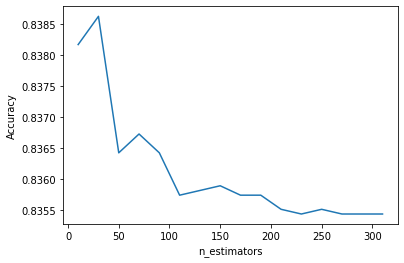

In [114]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [139]:
(estimator_range, accuracy_scores)

(range(10, 320, 20),
 [0.8381738256333957,
  0.8386299837169003,
  0.8364245158725678,
  0.8367287273077592,
  0.8364244001698256,
  0.8357399316720665,
  0.835815977299443,
  0.8358920229268193,
  0.835739902746381,
  0.8357399605977521,
  0.8355117947679489,
  0.8354357491405725,
  0.8355117947679489,
  0.8354357491405725,
  0.8354357491405725,
  0.8354356913111897])

## Tuning max features

When changing the number of variables x (features) we can see that the more  features, the better accuracy, in this cases 9 features is the best value for this parameter

In [128]:
# list of values to try for max_features
feature_range = range(1, n_features+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators='warn', max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Daniel 

C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Daniel 

Text(0, 0.5, 'Accuracy')

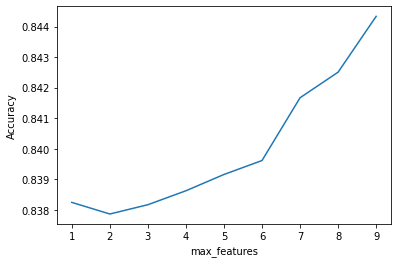

In [129]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

## Tuning max_depth


In [131]:
# list of values to try for max_features
depth_range = range(1, 15)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for depth in depth_range:
    clf = RandomForestClassifier(n_estimators='warn', max_depth=depth, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Daniel 

C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Daniel 

C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Daniel Camillo Rojas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Text(0, 0.5, 'Accuracy')

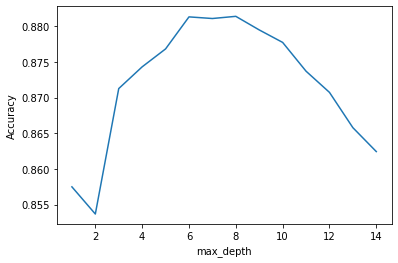

In [133]:
plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

## Fitting a Random Forest with the best parameters
Fitting the model with best parameters we find that best accuracy is 88%, a better result than the one found in exercise 8.5 of 83.9%

In [140]:
# max_features=9 is best and n_estimators=30 is sufficiently large
clf = RandomForestClassifier(n_estimators=30, max_features=9, max_depth=6,  random_state=1, n_jobs=-1)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features=9, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [141]:
cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()

0.881065152255417

# Exercise 8.7 

Using xgboost train a XGBClassifier 

Evaluate the accuracy on the testing set

### Even without tunning parameters in xgboost, if we compared to the results found with RFC (random forest classifier), we see that accuracy is greater than RFC. This is 83% in RFC without tunning  (exercise 8.5) vs  here to 87.9% in xgboost without tunning

In [152]:
from xgboost import XGBClassifier
clf = XGBClassifier()
clf

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

In [153]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)

(0.8989412897016361, 0.8790322580645161)

# Exercise 8.8

Using xgboost train a XGBClassifier 

Modify the parameters learning rate, gamma, colsample_bytree. Explain what each parameter means.

Evaluate the accuracy on the testing set

### Tunning Learning rate
he optimal Learning rate  value is 0.2 which gives the best accuracy

In [ ]:
clf = XGBClassifier(learning)
clf

In [190]:
learning_range=[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,0.4,0.5, 0.6, 0.7, 0.8,1]

In [191]:
# list to store the average Accuracy for each value of max_features
accuracy_scores = []


for learning in learning_range:
    clf = XGBClassifier(learning_rate=learning)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_scores.append(metrics.accuracy_score(y_pred, y_test.values))

Text(0, 0.5, 'Accuracy')

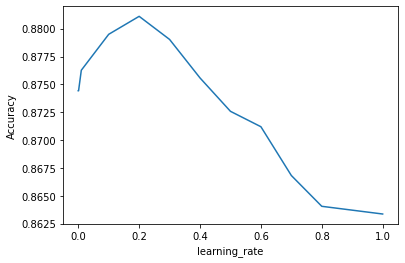

In [192]:
plt.plot(learning_range, accuracy_scores)
plt.xlabel('learning_rate')
plt.ylabel('Accuracy')

### Tunning Gamma
The optimal gamma value is 20 which gives the best accuracy

In [197]:
# list to store the average Accuracy for each value of max_features
accuracy_scores = []

gamma_range = range(0,300, 10)

for gamma in gamma_range:
    clf = XGBClassifier(gamma=gamma)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_scores.append(metrics.accuracy_score(y_pred, y_test.values))

Text(0, 0.5, 'Accuracy')

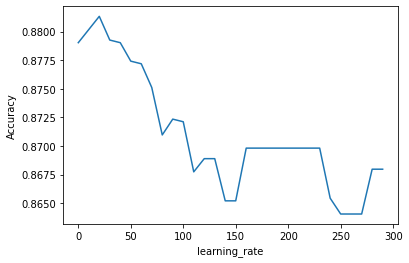

In [198]:
plt.plot(gamma_range, accuracy_scores)
plt.xlabel('learning_rate')
plt.ylabel('Accuracy')

In [199]:
 accuracy_scores

[0.8790322580645161,
 0.880184331797235,
 0.881336405529954,
 0.8792626728110599,
 0.8790322580645161,
 0.8774193548387097,
 0.8771889400921659,
 0.8751152073732719,
 0.8709677419354839,
 0.8723502304147466,
 0.8721198156682027,
 0.867741935483871,
 0.8688940092165899,
 0.8688940092165899,
 0.8652073732718893,
 0.8652073732718893,
 0.869815668202765,
 0.869815668202765,
 0.869815668202765,
 0.869815668202765,
 0.869815668202765,
 0.869815668202765,
 0.869815668202765,
 0.869815668202765,
 0.8654377880184332,
 0.8640552995391705,
 0.8640552995391705,
 0.8640552995391705,
 0.8679723502304147,
 0.8679723502304147]

### Tunning colsample_bytree

this parameter refers the fraction of features (randomly selected) that will be used to train each tree. Therefore its values are from (0, 1], of course it does not make sense to stablish cero, or a fraction very low which would mean only one variable.

Particulary in the results even though we see that the best Accuracy is achieve with 0.1 fraction of the vriables, it might be bether to use 100% fraction in order  to reduce the variance, it is preferable to select all variables this is the 100% portion.

In [214]:
colsample_bytree_range=[ 0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [215]:
accuracy_scores = []

for colsample in colsample_bytree_range:
    clf = XGBClassifier(colsample_bytree=colsample)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_scores.append(metrics.accuracy_score(y_pred, y_test.values))

Text(0, 0.5, 'Accuracy')

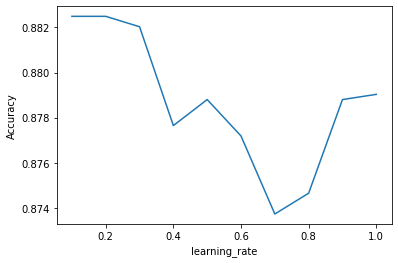

In [216]:
plt.plot(colsample_bytree_range, accuracy_scores)
plt.xlabel('learning_rate')
plt.ylabel('Accuracy')